# Audio preprocessing and analysis

### Video to Audio conversion

In [8]:
from moviepy.editor import *

In [9]:
def extract_and_save_audio(file_name):
    video = VideoFileClip("videos/"+file_name)
    audio = video.audio
    audio.write_audiofile("audios/"+file_name.rstrip(".mp4")+".wav", ffmpeg_params=["-ac", "1"])

In [10]:
# Reads the videos from videos/ folder and saves the audios to audios/ folder. Please create these folders
filename = "video_playback_scrum_cropped.mp4"
# extract_and_save_audio("Daily Standup.mp4")
# extract_and_save_audio("Dodgy Scrum Stand-up.mp4")
extract_and_save_audio(filename)

chunk:   6%|▌         | 252/4121 [00:00<00:01, 2517.82it/s, now=None]MoviePy - Writing audio in audios/video_playback_scrum_cropped.wav
                                                                      MoviePy - Done.


### Dividing the audio into small segments and saving them

In [11]:
from scipy.io.wavfile import read, write
import numpy as np
import matplotlib.pyplot as plt

In [12]:
def read_audio(audio_path):
    (sampling_rate, audio_data) = read(audio_path)
    return sampling_rate, audio_data

In [13]:
audio_filename = filename.rstrip(".mp4")+".wav"
sr, ad = read_audio("audios/"+audio_filename)
print(sr, ad.shape)

44100 (8241408,)


In [14]:
def describe_audio_data(sampling_rate, audio_data):
    print("Sampling rate: ", sampling_rate)
    print("Audio time (seconds): ", audio_data.size/sampling_rate)
    print("Audio data min: ", audio_data.min())
    print("Audio data max: ", audio_data.max())
    print("Audio data mean: ", audio_data.mean())
    print("Audio data std: ", audio_data.std())

In [15]:
describe_audio_data(sr, ad)

Sampling rate:  44100
Audio time (seconds):  186.88
Audio data min:  -22886
Audio data max:  22896
Audio data mean:  -3.8312111231478894
Audio data std:  2012.4343236944262


In [16]:
def visualize_audio_wave_over_time(sampling_rate, audio_data):
    time_array = np.arange(audio_data.size)/sampling_rate
    plt.plot(time_array, audio_data)
    plt.show()

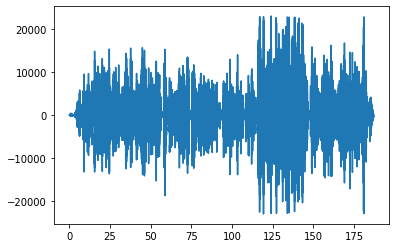

In [17]:
visualize_audio_wave_over_time(sr, ad)

### Noise filtering

In [22]:
from logmmse import logmmse

denoised_ad = logmmse(ad, sampling_rate=sr)
print(denoised_ad.shape)

(8237880,)


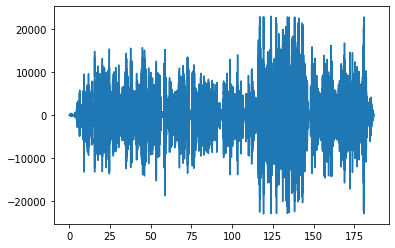

In [23]:
visualize_audio_wave_over_time(sr, denoised_ad)

In [24]:
# Saves denoised audio in audios/without noise/ folder. Please create this directory before running this
write("audios/without noise/"+audio_filename, sr, denoised_ad)

### Removing Silence

In [26]:
# Ref: https://hackernoon.com/audio-handling-basics-how-to-process-audio-files-using-python-cli-jo283u3y
def get_audio_segments(audio_data, segment_size, sr):
    # Fix-sized segmentation (breaks a signal into non-overlapping segments)
    signal_len = len(audio_data)
    segment_size_t = segment_size # segment size in seconds
    segment_size = segment_size * sr  # segment size in samples
    # Break signal into list of segments in a single-line Python code
    segments = np.array([audio_data[x:x + segment_size] for x in np.arange(0, signal_len, segment_size)])
    return segments

In [41]:
# Ref: https://hackernoon.com/audio-handling-basics-how-to-process-audio-files-using-python-cli-jo283u3y
def trim_silence(audio_segments, sr):
    # Remove pauses using an energy threshold = 50% of the median energy:
    energies = [(s**2).sum() / len(s) for s in audio_segments]
    
    # (attention: integer overflow would occure without normalization here!)
    thres = 0.25 * np.median(energies)
    print(thres)
    index_of_segments_to_keep = (np.where(energies > thres)[0])

    # get segments that have energies higher than a the threshold:
    segments2 = audio_segments[index_of_segments_to_keep]

    # concatenate segments to signal:
    new_signal = np.concatenate(segments2)

    visualize_audio_wave_over_time(sr, new_signal)

    return new_signal

437.7605612244898


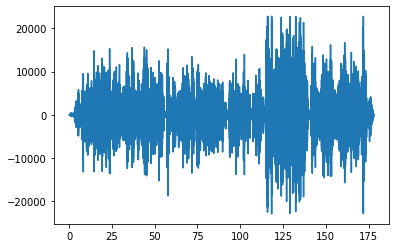

In [42]:
# Remove silence from audio with noise - The trimmed audio will be stored in audios/preprocessed/ folder so please create it before running this block
file_path = "audios/"+audio_filename
fs_wav, data_wav = read_audio(file_path)

segments = get_audio_segments(data_wav, 1, fs_wav)

clean_audio = trim_silence(segments, fs_wav)

write("audios/preprocessed/preprocessed_"+audio_filename, fs_wav, clean_audio)

428.2976077097506


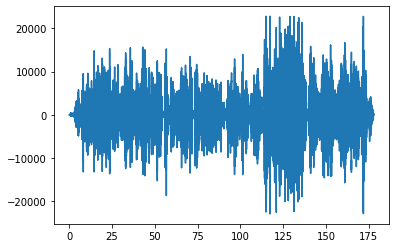

In [43]:
# Remove silence from audio without noise - The trimmed audio will be stored in audios/preprocessed/ folder so please create it before running this block
file_path = "audios/without noise/"+audio_filename
fs_wav, data_wav = read_audio(file_path)

segments = get_audio_segments(data_wav, 1, fs_wav)

clean_audio = trim_silence(segments, fs_wav)

write("audios/preprocessed/preprocessed_wo_noise_"+audio_filename, fs_wav, clean_audio)